In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
df = pd.read_csv('dataset_3.csv')

## Preprocessing and Analysis

In [3]:
df.drop(['No'], axis=1, inplace=True)

In [4]:
df.head()

,year,month,day,hour,A,B,C,D,E,F,G,H
0,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
df.dtypes

year       int64
month      int64
day        int64
hour       int64
A        float64
B          int64
C        float64
D        float64
E         object
F        float64
G          int64
H          int64
dtype: object

In [6]:
# checking for null values
df.isna().any()

year     False
month    False
day      False
hour     False
A         True
B        False
C        False
D        False
E        False
F        False
G        False
H        False
dtype: bool

In [7]:
df.A.describe()

count    41757.000000
mean        98.613215
std         92.050387
min          0.000000
25%         29.000000
50%         72.000000
75%        137.000000
max        994.000000
Name: A, dtype: float64

In [8]:
# sampling missing values from gaussian
A_stats = df.A[df.A.notnull()].describe()[['mean', 'std']]
A_null = df.loc[df.A.isnull(), 'A']
for i in range(len(A_null)):
    sample = np.random.normal(A_stats['mean'], A_stats['std'])
    while sample < 0:
        sample = np.random.normal(A_stats['mean'], A_stats['std'])
    A_null[A_null.index[i]] = sample
df.loc[df.A.isnull(), 'A'] = A_null

In [9]:
df.describe()

,year,month,day,hour,A,B,C,D,F,G,H
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,99.776194,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,91.498525,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,30.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,74.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,140.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [10]:
# one hot encoding for E
one_hot_E = pd.get_dummies(df.E)
one_hot_E.set_axis(['E-' + name for name in one_hot_E.columns], axis=1, inplace=True)
df.drop('E', axis=1, inplace=True)
df = df.join(one_hot_E)

## Splitting into training and testing

In [11]:
def split(train_ratio, df, shuffle=True):
    if shuffle:
        df = df.sample(frac=1)
    train_samples = int(train_ratio * len(df))
    return df.iloc[:train_samples].copy().reset_index(drop=True), df.iloc[train_samples:].copy().reset_index(drop=True)

In [12]:
df_train, df_test = split(0.75, df)

In [13]:
df_train.head()

,year,month,day,hour,A,B,C,D,F,G,H,E-NE,E-NW,E-SE,E-cv
0,2014,7,11,17,16.0,13,35.0,999.0,0.89,0,0,0,0,0,1
1,2013,2,21,1,67.0,-15,-6.0,1030.0,1.79,0,0,0,0,1,0
2,2014,12,16,17,10.0,-20,-3.0,1030.0,290.10,0,0,0,1,0,0
3,2011,12,7,17,15.0,-13,2.0,1033.0,67.96,0,0,0,1,0,0
4,2010,6,2,18,97.0,13,24.0,1016.0,8.05,0,0,0,0,1,0


In [14]:
df_test.head()

,year,month,day,hour,A,B,C,D,F,G,H,E-NE,E-NW,E-SE,E-cv
0,2011,7,23,15,293.0,27,32.0,1002.0,3.58,0,0,0,0,1,0
1,2013,6,19,5,86.0,18,21.0,1002.0,0.89,0,0,0,0,0,1
2,2010,12,9,4,158.0,-8,-2.0,1014.0,5.81,0,0,0,0,1,0
3,2014,7,3,0,110.0,21,23.0,1001.0,4.02,0,0,0,0,1,0
4,2010,11,24,1,238.0,-6,-1.0,1019.0,11.63,0,0,0,1,0,0


In [15]:
feature_cols = ['year', 'hour', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'E-NE', 'E-NW', 'E-SE', 'E-cv']
X_train = df_train[feature_cols]
Y_train = df_train.month
X_test = df_test[feature_cols]
Y_test = df_test.month

## Choosing criteria
* `entropy` performs slightly better over `gini`.

In [16]:
clf_1 = DecisionTreeClassifier()
clf_1 = clf_1.fit(X_train, Y_train)
Y_pred_1 = clf_1.predict(X_test)
print(f'Accuracy using gini: {metrics.accuracy_score(Y_test, Y_pred_1)}')

Accuracy using gini: 0.6881161007667032


In [17]:
clf_2 = DecisionTreeClassifier(criterion='entropy')
clf_2 = clf_2.fit(X_train, Y_train)
Y_pred_2 = clf_2.predict(X_test)
print(f'Accuracy using entropy: {metrics.accuracy_score(Y_test, Y_pred_2)}')

Accuracy using entropy: 0.6895764877692588


## Max Depths
* Plotting training and testing acc. vs max depth using entropy as criteria.
* Within the given max depths, depth of 30 gives best accuracy both on training and testing.

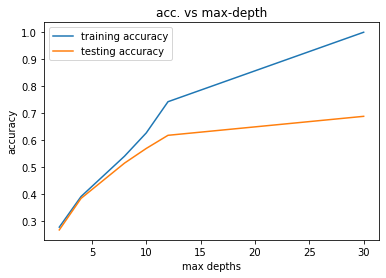

In [18]:
# moving forward with entropy
mx_depths = [2, 4, 8, 10, 12, 30]
test_acc = []
train_acc = []
for d in mx_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    clf = clf.fit(X_train, Y_train)
    train_acc.append(metrics.accuracy_score(Y_train, clf.predict(X_train)))
    test_acc.append(metrics.accuracy_score(Y_test, clf.predict(X_test)))
plt.plot(mx_depths, train_acc, label='training accuracy')
plt.plot(mx_depths, test_acc, label='testing accuracy')
plt.xlabel('max depths')
plt.ylabel('accuracy')
plt.title('acc. vs max-depth')
plt.legend()
plt.show()

## Ensemble

In [19]:
class DT_Ensemble:
    def __init__(self, num, criteria, mx_depth):
        self.trees = []
        self.num_trees = int(num)
        self.criteria = criteria
        self.mx_depth = mx_depth
        for _ in range(self.num_trees):
            self.trees.append(DecisionTreeClassifier(criterion=self.criteria, max_depth=self.mx_depth))
    def train(self, ratio, df):
        global feature_cols
        for i in range(self.num_trees):
            sub_df_train, _ = split(ratio, df)
            sub_x_train = sub_df_train[feature_cols]
            sub_y_train = sub_df_train.month
            self.trees[i] = self.trees[i].fit(sub_x_train, sub_y_train)
    def mode(l):
        d = {0: 0}
        mode_ = 0
        for x in l:
            d[x] = (d[x] + 1) if (x in d) else 1
            if d[x] > d[mode_]:
                mode_ = x
        return mode_
    def predict(self, x):
        outputs = []
        for i in range(self.num_trees):
            outputs.append(self.trees[i].predict(x))
        outputs = np.array(outputs)
        majority = []
        for i in range(len(x)):
            majority.append(DT_Ensemble.mode(outputs[:,i]))
        return np.array(majority)

In [20]:
dt_ensemble = DT_Ensemble(150, 'entropy', 4)
dt_ensemble.train(0.4, df_train)
Y_ensemble_pred = dt_ensemble.predict(X_test)
print(f'Ensemble testing accuracy for max_depth 4: {metrics.accuracy_score(Y_test, Y_ensemble_pred)}')

Ensemble testing accuracy for max_depth 4: 0.3953997809419496


## Ensemble w/ varying hyperparameters
* for a particular `max depth`, ensemble sizes aren't a distinguishing factor beyond a certain threshold
* as `max depth` increases, performance over both test and train set increases, although test set's increasing gradient seems to gradually decrease, which occurs due to overfitting on the training data

In [21]:
NUM_TREES_L = [1, 5, 15, 50, 100, 150, 200, 250]
MAX_DEPTHS_L = [5, 7, 13, 15, 25, 30]
train_acc_ens = {}
test_acc_ens = {}
for n in tqdm(NUM_TREES_L):
    for d in MAX_DEPTHS_L:
        dte = DT_Ensemble(n, 'entropy', d)
        dte.train(0.4, df_train)
        train_acc_ens[(n, d)] = metrics.accuracy_score(Y_train, dte.predict(X_train))
        test_acc_ens[(n, d)] = metrics.accuracy_score(Y_test, dte.predict(X_test))

100%|██████████| 8/8 [07:00<00:00, 52.60s/it]


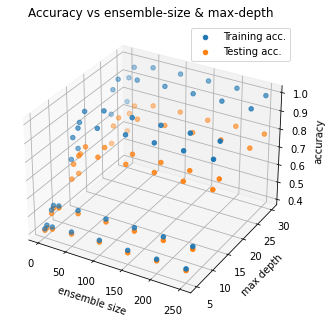

In [22]:
x_tr = []
y_tr = []
z_tr = []
x_te = []
y_te = []
z_te = []
for (n, d) in train_acc_ens:
    x_tr.append(n)
    y_tr.append(d)
    z_tr.append(train_acc_ens[(n, d)])
for (n, d) in test_acc_ens:
    x_te.append(n)
    y_te.append(d)
    z_te.append(test_acc_ens[(n, d)])

ax = Axes3D(plt.figure())
ax.scatter(x_tr, y_tr, z_tr, label='Training acc.')
ax.scatter(x_te, y_te, z_te, label='Testing acc.')
ax.set_xlabel('ensemble size')
ax.set_ylabel('max depth')
ax.set_zlabel('accuracy')
ax.legend()
plt.title('Accuracy vs ensemble-size & max-depth')
plt.show()